In [56]:
import pandas as pd
import seaborn as sns
import numpy as np

In [57]:
#df = pd.read_csv('Data_Latest.csv')

df = pd.read_csv('dataCompressed3_125_1000.csv')
print(list(df.columns))
df = df.drop('series_id', axis=1)

df.isna().sum()

['series_id', 'x_0', 'x_1', 'target']


x_0       0
x_1       0
target    0
dtype: int64

In [58]:
df.head()

,x_0,x_1,target
0,0.367913,-0.073622,0
1,0.156383,0.192457,0
2,-0.159244,0.634766,0
3,-0.438949,1.160518,0
4,-0.859950,1.773462,0


In [59]:
#df = df.drop('series_id', axis=1)
df.columns

Index(['x_0', 'x_1', 'target'], dtype='object')

In [60]:
features = list(df.columns)
features.remove("target")
features

['x_0', 'x_1']

In [61]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
df[features] = scaler.fit_transform(df[features])
df.head()

,x_0,x_1,target
0,0.293963,0.013621,0
1,0.289018,0.026415,0
2,0.281640,0.047682,0
3,0.275101,0.072962,0
4,0.265260,0.102435,0


In [62]:
import numpy as np
import pandas as pd
def create_sequences(data, seq_length):
    xs, ys = [], []
    for i in range(0, len(data) - seq_length, round(seq_length/2)):
        x = data[i:i+seq_length][['x_0', 'x_1']].values
        y0 = data.iloc[i]['target']
        y = data.iloc[i+seq_length]['target']
        #xs.append(x)
        #ys.append(y)
        if y0 == y:
            xs.append(x)
            ys.append(y)
    return np.array(xs), np.array(ys)
SEQ_LENGTH = 20
x_data, y_data = create_sequences(df, SEQ_LENGTH)
print(len(y_data))

46000


In [63]:
print(x_data[1])

[[0.18270771 0.23650754]
 [0.16678447 0.27395957]
 [0.15751737 0.29275994]
 [0.14491888 0.30658808]
 [0.13871824 0.32920256]
 [0.13455148 0.3482672 ]
 [0.13019644 0.36685671]
 [0.11765131 0.38675233]
 [0.10388787 0.39663932]
 [0.08706787 0.41407874]
 [0.07686506 0.4336506 ]
 [0.07484446 0.45131286]
 [0.06951319 0.47998986]
 [0.06325574 0.51595434]
 [0.05854294 0.55975393]
 [0.05308224 0.6006352 ]
 [0.05655365 0.63649335]
 [0.06874754 0.65729409]
 [0.0820709  0.6834427 ]
 [0.09490819 0.70947794]]


In [64]:
type(x_data)

numpy.ndarray

In [65]:
# Placeholder lists for the final training and test sets
x_train_list, x_test_list = [], []
y_train_list, y_test_list = [], []
for label in df['target'].unique():
    x_data_class, y_data_class = create_sequences(df[df['target'] == label], SEQ_LENGTH)
    train_size = int(len(x_data_class) * 0.8)

    # Split the data for this class
    x_train_class, x_test_class = x_data_class[:train_size], x_data_class[train_size:]
    y_train_class, y_test_class = y_data_class[:train_size], y_data_class[train_size:]

    # Append to the final lists
    x_train_list.append(x_train_class)
    x_test_list.append(x_test_class)
    y_train_list.append(y_train_class)
    y_test_list.append(y_test_class)

# Concatenate data from all classes to get the final training and test sets
x_train = np.concatenate(x_train_list, axis=0)
x_test = np.concatenate(x_test_list, axis=0)
y_train = np.concatenate(y_train_list, axis=0)
y_test = np.concatenate(y_test_list, axis=0)

In [66]:
# For training data
unique_labels_train, counts_train = np.unique(y_train, return_counts=True)
for label, count in zip(unique_labels_train, counts_train):
    print(f"Label {label} in training data: {count} instances")

print("\n")  # Just to separate the outputs

# For test data
unique_labels_test, counts_test = np.unique(y_test, return_counts=True)
for label, count in zip(unique_labels_test, counts_test):
    print(f"Label {label} in test data: {count} instances")

Label 0.0 in training data: 3706 instances
Label 1.0 in training data: 3411 instances
Label 2.0 in training data: 2884 instances
Label 3.0 in training data: 2589 instances
Label 4.0 in training data: 4190 instances
Label 5.0 in training data: 3360 instances
Label 6.0 in training data: 3860 instances
Label 7.0 in training data: 6146 instances
Label 8.0 in training data: 3672 instances
Label 9.0 in training data: 2980 instances


Label 0.0 in test data: 927 instances
Label 1.0 in test data: 853 instances
Label 2.0 in test data: 722 instances
Label 3.0 in test data: 648 instances
Label 4.0 in test data: 1048 instances
Label 5.0 in test data: 841 instances
Label 6.0 in test data: 966 instances
Label 7.0 in test data: 1537 instances
Label 8.0 in test data: 919 instances
Label 9.0 in test data: 746 instances


In [67]:
from tensorflow.keras.metrics import SparseCategoricalAccuracy
from tensorflow.keras import Sequential
from tensorflow.keras.layers import LSTM, BatchNormalization, Dense, Flatten

metrics = [SparseCategoricalAccuracy(name="accuracy")]

model = Sequential()
model.add(LSTM(300, activation='relu', return_sequences=True, input_shape=(SEQ_LENGTH, 2)))
model.add(BatchNormalization())
model.add(LSTM(200, activation='relu', return_sequences=True))
model.add(BatchNormalization())
model.add(LSTM(100, activation='relu', return_sequences=True))
model.add(BatchNormalization())
model.add(LSTM(50, activation='relu'))
model.add(BatchNormalization())
model.add(Flatten())
model.add(Dense(200, activation='relu'))
model.add(Dense(10, activation='softmax'))

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [68]:
#!pip install keras-tuner

In [69]:
from tensorflow.python.client import device_lib
import tensorflow as tf
def get_available_devices():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos]

print(get_available_devices())
print(tf.config.list_physical_devices('GPU'))

['/device:CPU:0']
[]


In [70]:
from keras_tuner import RandomSearch

def build_model(hp):
    model = Sequential()
    model.add(LSTM(
        units=hp.Int('units_1', min_value=200, max_value=500, step=50),
        activation='relu',
        return_sequences=True,
        input_shape=(SEQ_LENGTH, 2)
    ))
    model.add(BatchNormalization())
    model.add(LSTM(
        units=hp.Int('units_2', min_value=100, max_value=300, step=50),
        activation='relu',
        return_sequences=True
    ))
    model.add(BatchNormalization())
    model.add(LSTM(
        units=hp.Int('units_3', min_value=50, max_value=200, step=50),
        activation='relu'
    ))
    model.add(BatchNormalization())
    model.add(Flatten())
    model.add(Dense(
        units=hp.Int('dense_units', min_value=100, max_value=300, step=50),
        activation='relu'
    ))
    model.add(Dense(10, activation='softmax'))

    model.compile(
        optimizer=hp.Choice('optimizer', values=['adam', 'sgd', 'rmsprop']),
        loss='sparse_categorical_crossentropy',
        metrics=metrics
    )
    return model

In [71]:
tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=10,  # or however many trials you wish to run
    #directory='C:\\Users\\evenf\\OneDrive - Universitetet i Agder\\Even and Hamza PhD project work\\Human trajectory simulations paper\\LSTM Model with Dataset\\keras_tuner_dir'
)

tuner.search(x_train, y_train, epochs=10, validation_data=(x_test, y_test))

Trial 10 Complete [00h 09m 49s]
val_accuracy: 0.9366785883903503

Best val_accuracy So Far: 0.9522102475166321
Total elapsed time: 01h 44m 50s
INFO:tensorflow:Oracle triggered exit


In [72]:
from tensorflow.keras.callbacks import Callback, CSVLogger, EarlyStopping, LearningRateScheduler, ReduceLROnPlateau
import tensorflow as tf
csv_logger = CSVLogger('logs.csv', separator = ',', append = True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.01, patience=3, verbose=1)
def custom_lr_schedule(epoch):
    if epoch < 30:
        return 0.001
    else:
        return 0.001 * tf.math.exp(0.1 * (30 - epoch))
lr_scheduler = LearningRateScheduler(custom_lr_schedule, verbose=1)
lstm_history = model.fit(x_train, y_train, epochs=100, validation_data=(x_test, y_test), batch_size=16, callbacks=[reduce_lr, lr_scheduler, csv_logger])

# Save model and history
model.save('model_lstm.keras')
np.save('history_lstm.npy',lstm_history.history)


Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/100


2300/2300 [==============================] - 124s 53ms/step - loss: 0.5548 - accuracy: 0.7753 - val_loss: 0.2035 - val_accuracy: 0.9054 - lr: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.001.
Epoch 2/100
2300/2300 [==============================] - 122s 53ms/step - loss: 0.2324 - accuracy: 0.9014 - val_loss: 0.1461 - val_accuracy: 0.9354 - lr: 0.0010

Epoch 3: LearningRateScheduler setting learning rate to 0.001.
Epoch 3/100
2300/2300 [==============================] - 124s 54ms/step - loss: 0.1922 - accuracy: 0.9165 - val_loss: 0.1684 - val_accuracy: 0.9298 - lr: 0.0010

Epoch 4: LearningRateScheduler setting learning rate to 0.001.
Epoch 4/100
2300/2300 [==============================] - 127s 55ms/step - loss: 0.1763 - accuracy: 0.9249 - val_loss: 0.1703 - val_accuracy: 0.9259 - lr: 0.0010

Epoch 5: LearningRateScheduler setting learning rate to 0.001.
Epoch 5/100
2300/2300 [==============================] - ETA: 0s - loss: 0.1627 - accuracy: 0.9315
Epoch 5: Redu

KeyboardInterrupt: 

In [ ]:
predictions = model.predict(x_test)
classes_x=np.argmax(predictions,axis=1)

print(x_test[1].shape)
print(predictions.shape)
print(classes_x)

29/29 [==============================] - 1s 17ms/step
(20, 2)
(919, 10)
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 4 1 1 1 1 1 1 1 1 7 1 1 1 1 1 1 1 7 1
 1 1 1 7 1 1 1 1 1 1 1 4 1 1 1 4 1 1 1 1 1 1 1 1 4 1 1 1 1 1 1 1 4 1 1 1 1
 1 1 1 1 4 1 1 1 1 1 1 1 7 1 1 1 7 1 1 1 1 4 1 1 1 4 1 1 1 1 2 2 2 2 2 2 2
 2 2 2 8 2 2 2 8 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 4 4 4 4 4 4 4 4 4 7 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 1 4
 4 4 4 1 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 1 4 4 4 4 4 4 4 4 4 1 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5
 5 5 5 5 5 5 5 5 5 5 5 5 6 5

In [ ]:
cm = tf.math.confusion_matrix(labels=y_test, predictions=classes_x, num_classes=10)
cm

<tf.Tensor: shape=(10, 10), dtype=int32, numpy=
array([[ 92,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,  73,   0,   0,   8,   0,   0,   5,   0,   0],
       [  0,   0,  70,   0,   0,   0,   0,   0,   2,   0],
       [  0,   0,   0,  65,   0,   0,   0,   0,   0,   0],
       [  0,   4,   0,   0, 100,   0,   0,   1,   0,   0],
       [  0,   0,   0,   0,   0,  80,   4,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,  90,   6,   0,   0],
       [  0,   0,   0,   0,   2,   1,  10, 140,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,  92,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,  74]])>

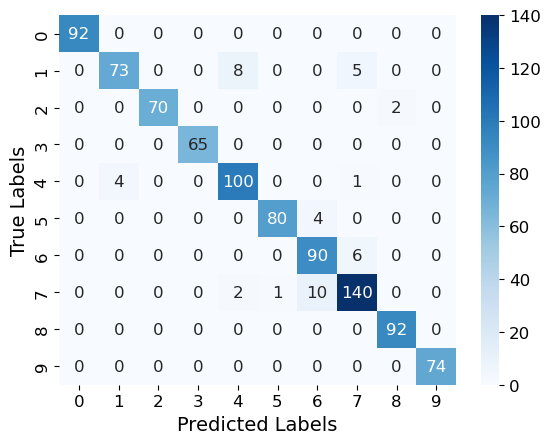

In [ ]:
import matplotlib.pyplot as plt
font_style = {'family' : 'sans-serif', # 'Times New Roman'
        'weight' : 'normal',
        'size'   : 14}

font_style_nr = {'family' : 'sans-serif',
        'weight' : 'normal',
        'size'   : 12}

hm = sns.heatmap(cm, annot=True, cmap='Blues',fmt='g', annot_kws={'fontdict': font_style_nr})
hm.set_xticklabels(hm.get_xticklabels(), fontdict=font_style_nr)
hm.set_yticklabels(hm.get_yticklabels(), fontdict=font_style_nr)
cbar = hm.collections[0].colorbar
# Set font style for colorbar tick labels
for label in cbar.ax.get_yticklabels():
    label.set_fontsize(12)
    label.set_fontname('sans-serif')
    label.set_fontweight('normal')

plt.xlabel('Predicted Labels', fontdict=font_style)
plt.ylabel('True Labels', fontdict=font_style)
plt.show()

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test, classes_x))

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        92
         1.0       0.95      0.85      0.90        86
         2.0       1.00      0.97      0.99        72
         3.0       1.00      1.00      1.00        65
         4.0       0.91      0.95      0.93       105
         5.0       0.99      0.95      0.97        84
         6.0       0.87      0.94      0.90        96
         7.0       0.92      0.92      0.92       153
         8.0       0.98      1.00      0.99        92
         9.0       1.00      1.00      1.00        74

    accuracy                           0.95       919
   macro avg       0.96      0.96      0.96       919
weighted avg       0.95      0.95      0.95       919



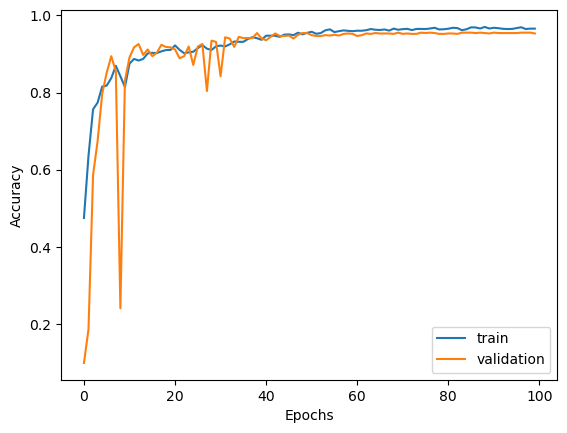

In [ ]:
history = lstm_history


fig, ax = plt.subplots()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'], loc='best')
plt.show()

image_format = 'pdf' # e.g .png, .svg, etc.
image_name = 'accuracy.pdf'

#fig.savefig(image_name, format=image_format, dpi=1200)